# MACID tutorial

In [2]:
#importing necessary libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60
import sys
sys.path.append("..") #TODO: make /cid a package, then delete this
import numpy as np
from core.cid import CID
from core.macid import MACID
from core.get_paths import find_active_path, get_motifs, find_all_dir_paths
from core.cpd import FunctionCPD, DecisionDomain, UniformRandomCPD

Autosaving every 60 seconds


In the CID tutorial, we showed how to instantiate single-agent causal influence diagrams (CIDs) and models (CIMs). In this section, we demonstrate how to use our codebase for multi-agent causal influence diagrams (MACIDs)

<div class="alert alert-block alert-info">
<b>Definition:</b> 
A <b>multi-agent influence diagram (MAID)</b> (Hammond et al, 2021) is a triple $(\textbf{N}, \textbf{V}, \textbf{E})$, where:
    
 - $\textbf{N} = \{1,\dots,n\}$ is a set of agents.
 - $(\textbf{V}, \textbf{E})$ is a directed acyclic graph (DAG) with a set of vertices $\textbf{V}$ connected by directed edges $\textbf{E} \subseteq \textbf{V} \times \textbf{V}$. These vertices are partitioned into $\textbf{D}$, $\textbf{U}$, and $\textbf{X}$, which correspond to decision, utility, and chance nodes respectively. $\textbf{D}$ and $\textbf{U}$ are in turn partitioned into $\{\textbf{D}^i\}_{i\in \textbf{N}}$ and $\{\textbf{U}^i\}_{i\in \textbf{N}}$ corresponding to their association with a particular agent $i \in \textbf{N}$.
   
</div> 


<div class="alert alert-block alert-info">
<b>Definition:</b> 
    
 A <b>multi-agent influence model (MAIM)</b> (Hammond et al, 2021) is a tuple $(\textbf{N}, \textbf{V}, \textbf{E}, \theta)$ where $(\textbf{N}, \textbf{V}, \textbf{E})$ is a MAID and:

- $\theta \in \Theta$ is a particular parametrisation over the nodes in the graph specifying a finite domain $\textbf{dom}(V)$ for each node $V \in \textbf{V}$, real-valued domains $\textbf{dom}(U) \subset \mathbb{R}$ for each $U \in \textbf{U}$, and a set of conditional probability distributions (CPDs) $\Pr(\textbf{V} \mid \textbf{Pa}_V)$ for every chance and utility node. Taken together, the CPDs form a partial distribution $\Pr(\textbf{X},\textbf{U} : \textbf{D}) = \prod_{V \in \textbf{V} \setminus \textbf{D}} \Pr(V \mid \textbf{Pa}_V)$ over the variables in the MAID.
 - The value $u \in \textbf{dom}(U)$ of a utility node is a deterministic function of the values of its parents $\textbf{pa}_U \in \textbf{dom}(\textbf{Pa}_U)$.
</div> 

As we did in the CID basics tutorial, we'll start by showing how to instantiate a MACID and showcase some useful methods. We'll then show how to parameterise them as MACIMs. 

__Job Hiring Example:__ _A company employs an AI system to automate their hiring process. A naturally hard-working or naturally lazy worker wants a job at this company and believes that a university degree will increase their chance of being hired; however, they also know that they will suffer an opportunity cost from three years of studying. A hard-worker will cope better with a university workload than a lazy worker. The algorithm must decide, on behalf of the company, whether to hire the worker. The company wants to hire someone who is naturally hard-working, but the algorithm can't observe the worker's temperament directly, it can only infer it indirectly through whether or not the worker attended university._

We can construct a MACID for this example where:

- X = whether the worker is naturally hard working or lazy (chance node)
- D1 and U1 correspond to the worker's decision whether or not to go to university (and their utility)
- D2 and U2 correspond to the algorithm's decision whether or not to hire the worker (and the company's utility)

In [3]:
macid = MACID([
        ('X', 'D1'),  #specifying the nodes and edges.
        ('X', 'U2'),
        ('X', 'U1'),
        ('D1', 'D2'),
        ('D2', 'U1'),
        ('D2', 'U2'),
        ],
        {1: {'D': ['D1'], 'U': ['U1']}, # specifying each agent's decision and utility nodes.
         2: {'D': ['D2'], 'U': ['U2']}})

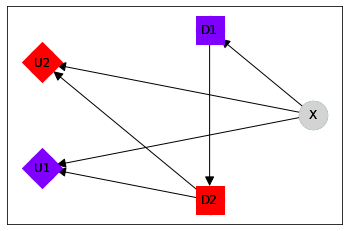

In [4]:
macid.draw()

Consistent with CIDs, chance nodes are drawn as circles, decision nodes are drawn as rectangles, and utility nodes are drawn as diamonds. Because we now have more than one player, we reserve colouring to denote agent membership; each agent of the game is assigned a unique colour.

## References

LHammond, L., Fox, J., Everitt, T., Abate, A., & Wooldridge, M. (2021). Equilibrium Refinements for Multi-Agent Influence Diagrams: Theory and Practice. arXiv preprint arXiv:2102.05008.